In [1]:
import os
import re

import keras.metrics
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras import layers, optimizers
from pymystem3 import Mystem
from string import punctuation
from wordcloud import WordCloud
from nltk.corpus import stopwords
from simple_elmo import ElmoModel
from tensorflow.keras import activations
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.sequence import pad_sequences

tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrysalis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read books

In [2]:
#dummy stub
first_author_name = "Nekrasov"
second_author_name = "Pushkin"

#appending all books of an author into books_first, books_second
def read_books(author_name):
    books_text = ""
    for book_name in os.listdir(f"./books_ru/poems/{author_name}"):
        book_file = open(f"./books_ru/poems/{author_name}/{book_name}", "r", encoding='utf8', errors='replace')
        books_text += " " + book_file.read()
        book_file.close()
    return books_text

books_first = read_books(first_author_name)
books_second = read_books(second_author_name)

author_1 = pd.DataFrame({"Author": [first_author_name], "label": 0, "Text": [books_first]})
author_2 = pd.DataFrame({"Author": [second_author_name], "label": 1, "Text": [books_second]})

author_1.head()

,Author,label,Text
0,Nekrasov,0,Николай Некрасов\nВ ДОРОГЕ\n«Скучно! скучно!....


In [3]:
author_2.head()

,Author,label,Text
0,Pushkin,1,Александр Пушкин\n19 ОКТЯБРЯ\nРоняет лес багр...


Clean text from punctuation

In [4]:
russian_stopwords = stopwords.words('russian')
mystem = Mystem()


#Preprocess function

def preprocess_text(text):
    text = re.sub(r'[^ЁёА-я\s]', ' ', text)
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = re.sub(r' {2,}', ' ', text)

    lemmas = mystem.lemmatize(text.lower())
    tokens = [token for token in lemmas if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text


author_1['Text'][0] = preprocess_text(author_1['Text'][0])
author_2['Text'][0] = preprocess_text(author_2['Text'][0])
authors = [author_1, author_2]

author_1.head()

C:\Users\CHRYSA~1\AppData\Local\Temp/ipykernel_10068/2939638234.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_1['Text'][0] = preprocess_text(author_1['Text'][0])
C:\Users\CHRYSA~1\AppData\Local\Temp/ipykernel_10068/2939638234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_2['Text'][0] = preprocess_text(author_2['Text'][0])


,Author,label,Text
0,Nekrasov,0,николай некрасов дорога скучно скучно ямщик уд...


In [5]:
author_2.head()

,Author,label,Text
0,Pushkin,1,александр пушкин октябрь ронять лес багряный с...


VISUALIZING THE DATA

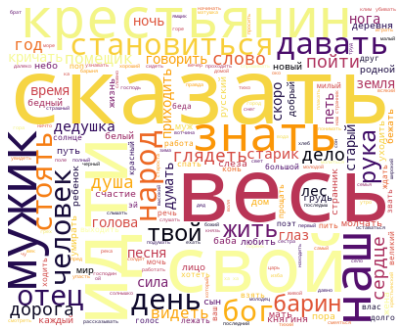

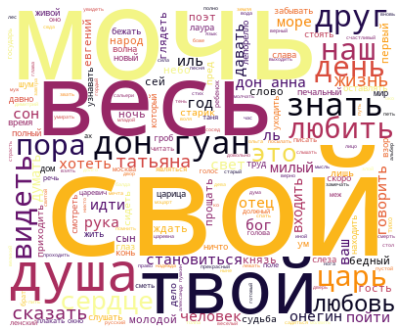

In [6]:
for book in authors:
    wordcloud = WordCloud(background_color="white",
                          stopwords=russian_stopwords,
                          mode="RGBA",
                          width=400,
                          height=330,
                          colormap='inferno').generate(book['Text'][0])
    # Display the generated image:
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Count and visualize as barplots

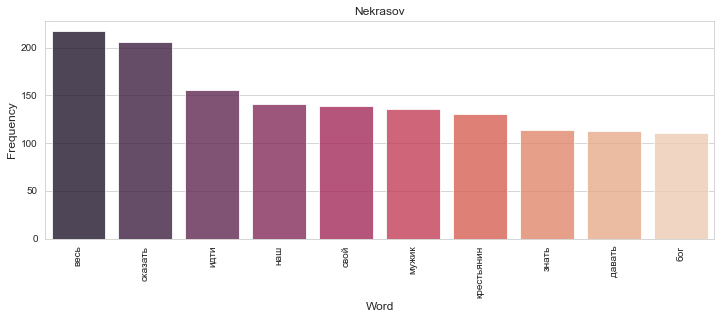

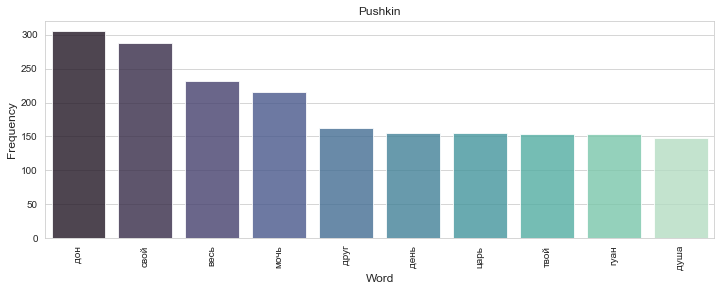

In [7]:
from collections import Counter

sns_palette = ["rocket", "mako", "magma", "rocket_r"]
sns.set_style("whitegrid")
for i, book in enumerate(authors):
    cnt_pro = np.asarray(Counter(book['Text'][0].split()).most_common(10))
    occ_df = pd.DataFrame({'word': cnt_pro[:, 0], 'count': [int(num) for num in cnt_pro[:, 1]]})
    plt.figure(figsize=(12, 4))
    sns.barplot(x='word', y='count', alpha=0.8, data=occ_df, palette=sns_palette[i])
    plt.title(book['Author'][0])
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Word', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

d:\study\semester 9\gan_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


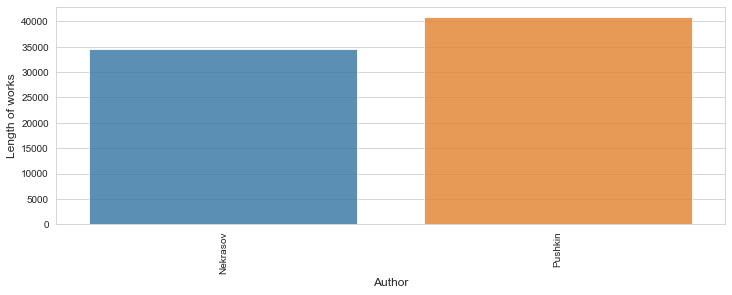

In [8]:
plt.figure(figsize=(12,4))
words = []
names = []
for book in authors:
    words.append(len(book['Text'][0].split()))
    names.append(book['Author'][0])

sns.barplot(names, words, alpha=0.8)
plt.ylabel('Length of works', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
dataset = pd.DataFrame(columns=['Author', 'Text', 'Vector'])
for author in authors:
    words = author['Text'][0].split()
    chunks = [words[i - 40:i] for i in range(40, len(words), 40)]
    temp_df = pd.DataFrame({'Author': author['Author'][0], 'label': author['label'][0], 'Text': chunks})
    dataset = dataset.append(temp_df)

dataset


,Author,Text,Vector,label
0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям...",NaN,0.0
1,Nekrasov,"[варган, играть, читать, весь, дворянский, ман...",NaN,0.0
2,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых...",NaN,0.0
3,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ...",NaN,0.0
4,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р...",NaN,0.0
...,...,...,...,...
1015,Pushkin,"[таилася, угасать, пламень, страстный, веселие...",NaN,1.0
1016,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать...",NaN,1.0
1017,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ...",NaN,1.0
1018,Pushkin,"[подлец, попович, красовский, пропускать, алек...",NaN,1.0


In [10]:
elmo = ElmoModel()
elmo.load("./212/", max_batch_size=40)

2021-11-06 21:47:50,976 : INFO : Loading model from ./212/...
2021-11-06 21:47:51,043 : INFO : We will cache the vocabulary of 100 tokens.
d:\study\semester 9\gan_env\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
d:\study\semester 9\gan_env\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


'The model is now loaded.'

In [11]:
authors_embeddings = elmo.get_elmo_vectors(list(dataset['Text']))
authors_embeddings.shape

2021-11-06 21:48:21,984 : INFO : Warming up ELMo on 40 sentences...
2021-11-06 21:48:29,257 : INFO : Warming up finished.
2021-11-06 21:48:29,265 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,386 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,508 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,628 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,753 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,870 : INFO : Texts in the current batch: 40
2021-11-06 21:48:29,994 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,115 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,237 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,354 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,476 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,593 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,714 : INFO : Texts in the current batch: 40
2021-11-06 21:48:30,834 : INFO : Texts in the 

(1884, 40, 1024)

In [12]:
dataset['Vector'] = authors_embeddings.tolist()
dataset

,Author,Text,Vector,label
0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям...","[[0.12611262500286102, -0.23871806263923645, -...",0.0
1,Nekrasov,"[варган, играть, читать, весь, дворянский, ман...","[[-0.35023772716522217, 0.46841204166412354, 0...",0.0
2,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых...","[[-0.2916157841682434, -0.557454526424408, -0....",0.0
3,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ...","[[-0.2584365904331207, 0.2403867095708847, 0.3...",0.0
4,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р...","[[0.003845836967229843, -0.5180366039276123, 0...",0.0
...,...,...,...,...
1015,Pushkin,"[таилася, угасать, пламень, страстный, веселие...","[[0.08735233545303345, -0.5055371522903442, -0...",1.0
1016,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать...","[[-0.05773055553436279, 0.009401366114616394, ...",1.0
1017,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ...","[[0.20898345112800598, -0.3496682643890381, -0...",1.0
1018,Pushkin,"[подлец, попович, красовский, пропускать, алек...","[[-0.34734565019607544, -1.1561857461929321, -...",1.0


In [13]:
X = np.asarray(dataset['Vector'].tolist())
Y = np.asarray(dataset['label'].tolist())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

pd.DataFrame({'Train': [X_train.shape, Y_train.shape], 'Test': [X_test.shape, Y_test.shape]}, index=['X', 'Y'])

,Train,Test
X,"(1601, 40, 1024)","(283, 40, 1024)"
Y,"(1601,)","(283,)"


In [25]:
# init layer
input_shape = layers.Input(shape=X_train[0].shape)

CNN_1 = layers.Conv1D(200, kernel_size=3, use_bias=True)(input_shape)
CNN_1 = layers.GlobalMaxPooling1D()(CNN_1)

CNN_2 = layers.Conv1D(200, kernel_size=4, use_bias=True)(input_shape)
CNN_2 = layers.GlobalMaxPooling1D()(CNN_2)

CNN_3 = layers.Conv1D(200, kernel_size=5, use_bias=True)(input_shape)
CNN_3 = layers.GlobalMaxPooling1D()(CNN_3)

merged = layers.Concatenate(axis=1)([CNN_1, CNN_2, CNN_3])

model = layers.Dense(100, activation='relu')(merged)
model = layers.Dropout(rate=.5)(model)
model = layers.Dense(3, activation='softmax')(model)
#model = layers.Softmax()(model)

cnn = Model(inputs=input_shape, outputs=model, name="CNN")

print(cnn.summary(line_length=140))

Model: "CNN"
____________________________________________________________________________________________________________________________________________
Layer (type)                                  Output Shape                   Param #         Connected to                                   
input_3 (InputLayer)                          [(None, 40, 1024)]             0                                                              
____________________________________________________________________________________________________________________________________________
conv1d_6 (Conv1D)                             (None, 38, 200)                614600          input_3[0][0]                                  
____________________________________________________________________________________________________________________________________________
conv1d_7 (Conv1D)                             (None, 37, 200)                819400          input_3[0][0]                                  


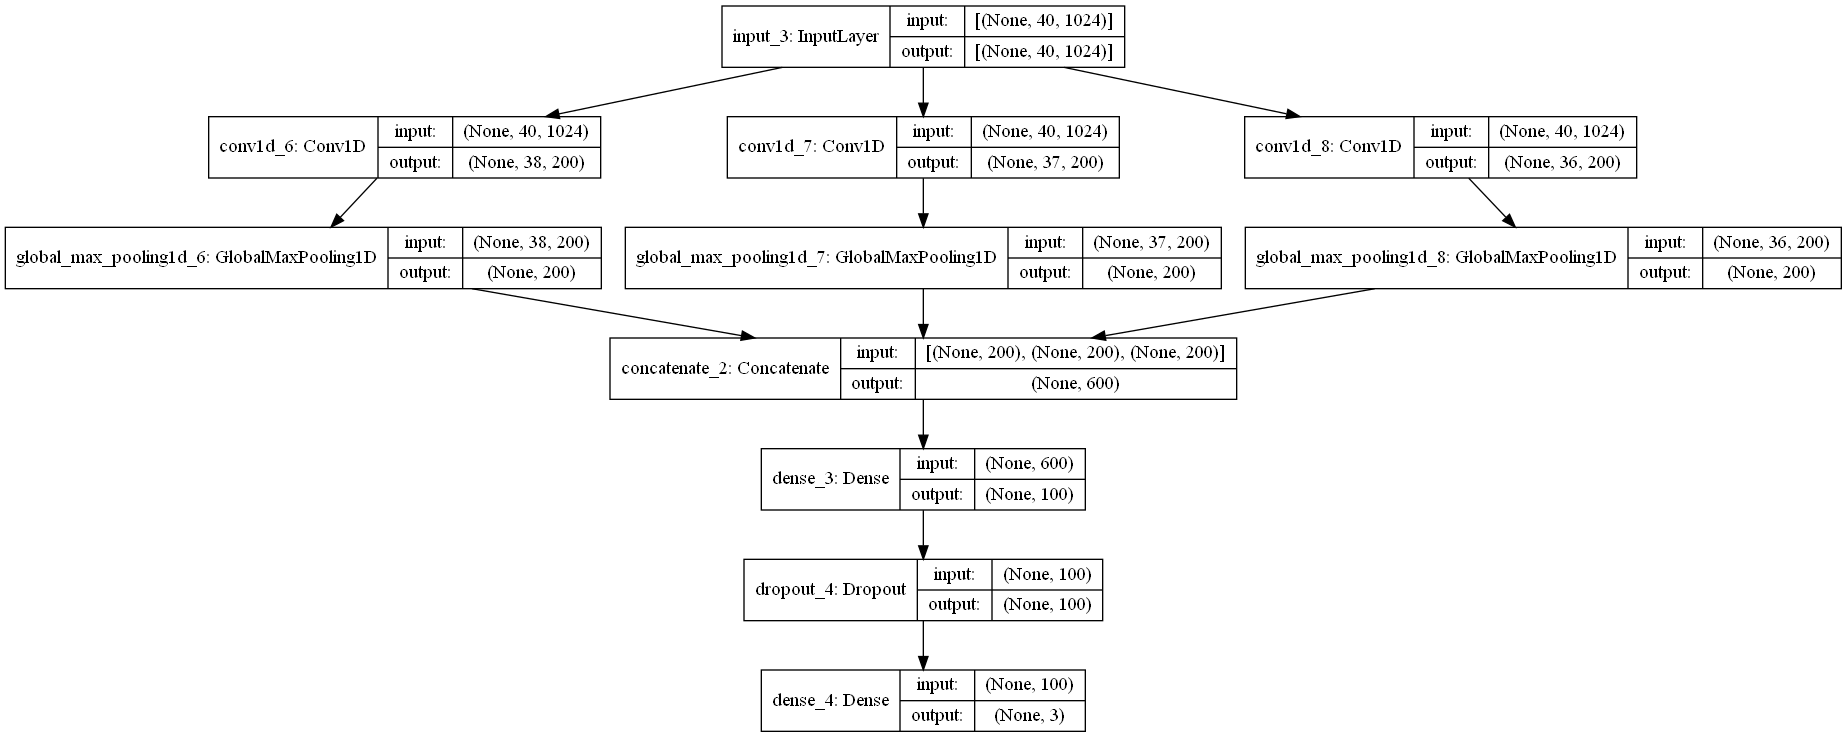

In [26]:
plot_model(cnn, "cnn.png", show_shapes=True)

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['acc'])
history = cnn.fit(X_train, Y_train, epochs=20, batch_size=50, verbose=2)

Train on 1601 samples
Epoch 1/20
1601/1601 - 1s - loss: 0.7358 - acc: 0.7208
Epoch 2/20
1601/1601 - 0s - loss: 0.3927 - acc: 0.8307
Epoch 3/20
1601/1601 - 0s - loss: 0.4257 - acc: 0.8251
Epoch 4/20
1601/1601 - 0s - loss: 0.2831 - acc: 0.8801
Epoch 5/20
1601/1601 - 1s - loss: 0.1980 - acc: 0.9188
Epoch 6/20
1601/1601 - 0s - loss: 0.1360 - acc: 0.9513
Epoch 7/20
1601/1601 - 0s - loss: 0.0751 - acc: 0.9750
Epoch 8/20
1601/1601 - 0s - loss: 0.0376 - acc: 0.9925
Epoch 9/20
1601/1601 - 0s - loss: 0.0245 - acc: 0.9969
Epoch 10/20
1601/1601 - 0s - loss: 0.0223 - acc: 0.9919
Epoch 11/20
1601/1601 - 0s - loss: 0.0210 - acc: 0.9925
Epoch 12/20
1601/1601 - 0s - loss: 0.0116 - acc: 0.9975
Epoch 13/20
1601/1601 - 1s - loss: 0.0074 - acc: 0.9981
Epoch 14/20
1601/1601 - 1s - loss: 0.0105 - acc: 0.9975
Epoch 15/20
1601/1601 - 1s - loss: 0.0063 - acc: 0.9994
Epoch 16/20
1601/1601 - 1s - loss: 0.0037 - acc: 0.9988
Epoch 17/20
1601/1601 - 0s - loss: 0.0049 - acc: 0.9994
Epoch 18/20
1601/1601 - 1s - loss: 

In [28]:
# evaluate the model
_, train_acc = cnn.evaluate(X_train, Y_train, verbose=2)
_, test_acc = cnn.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

d:\study\semester 9\gan_env\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train: 1.000, Test: 0.8975


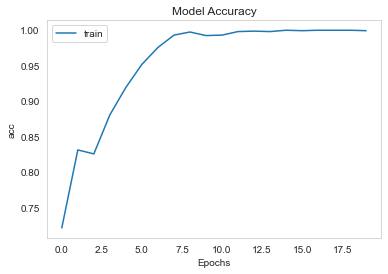

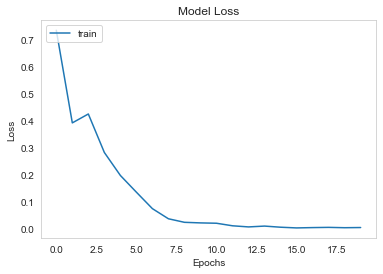

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_loss.png')

In [30]:
predict_x = cnn.predict(X_test)
Y_pred = np.argmax(predict_x,axis=1)

df_test = pd.DataFrame({'true': Y_test, 'pred':Y_pred})
tn, fp, fn, tp = confusion_matrix(df_test.true, df_test.pred).ravel()
c_matrix = pd.DataFrame({1: [tp, fp], 0: [fn, tn]}, index=[1, 0])
#print(f"confusion matrix:\n {}")
print("Confusion Matrix:")
print(c_matrix)
print(classification_report(df_test.true, df_test.pred))

Confusion Matrix:
     1    0
1  141   12
0   17  113
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       130
         1.0       0.89      0.92      0.91       153

    accuracy                           0.90       283
   macro avg       0.90      0.90      0.90       283
weighted avg       0.90      0.90      0.90       283



Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 40, 1024)]        0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80)                340800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                2430      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 93        
Total params: 343,323
Trainable params: 343,323
Non-trainable params: 0
______________________________________________________

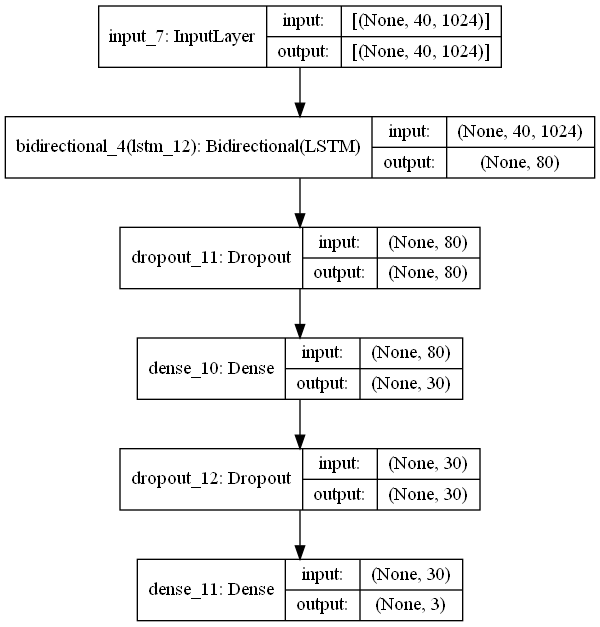

In [38]:
input_shape = layers.Input(shape=X_train[0].shape)

forward_lstm = layers.LSTM(40)#(input_shape)
backward_lstm = layers.LSTM(40, go_backwards=True)#(input_shape)

model = layers.Bidirectional(forward_lstm, backward_layer=backward_lstm)(input_shape)
model = layers.Dropout(rate=.2)(model)
model = layers.Dense(30, activation='relu')(model)
model = layers.Dropout(rate=.2)(model)
model = layers.Dense(3, activation='softmax')(model)
#model = layers.Dense(3, activation='softmax')(model)
bilstm = Model(inputs=input_shape, outputs=model, name="BiLSTM")
# output model skeleton
print(bilstm.summary())
plot_model(bilstm, "bilstm.png", show_shapes=True)

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bilstm.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['acc'])
history = bilstm.fit(X_train, Y_train, epochs=10, batch_size=50, verbose=2)

Train on 1601 samples
Epoch 1/10
1601/1601 - 3s - loss: 0.6695 - acc: 0.6802
Epoch 2/10
1601/1601 - 2s - loss: 0.4284 - acc: 0.8282
Epoch 3/10
1601/1601 - 2s - loss: 0.3179 - acc: 0.8770
Epoch 4/10
1601/1601 - 2s - loss: 0.2603 - acc: 0.9019
Epoch 5/10
1601/1601 - 2s - loss: 0.2061 - acc: 0.9313
Epoch 6/10
1601/1601 - 2s - loss: 0.1707 - acc: 0.9357
Epoch 7/10
1601/1601 - 2s - loss: 0.0999 - acc: 0.9663
Epoch 8/10
1601/1601 - 2s - loss: 0.0723 - acc: 0.9731
Epoch 9/10
1601/1601 - 2s - loss: 0.0789 - acc: 0.9731
Epoch 10/10
1601/1601 - 2s - loss: 0.0513 - acc: 0.9838


In [41]:
# evaluate the model
_, train_acc = bilstm.evaluate(X_train, Y_train, verbose=2)
_, test_acc = bilstm.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

d:\study\semester 9\gan_env\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train: 0.998, Test: 0.8905


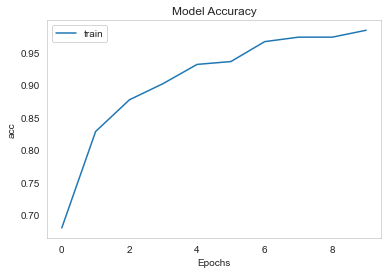

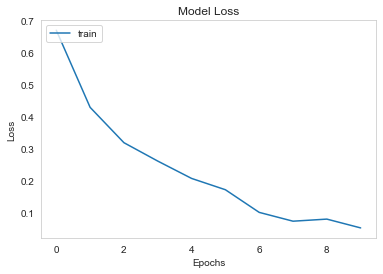

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_loss.png')

In [43]:
predict_x = bilstm.predict(X_test)
Y_pred = np.argmax(predict_x,axis=1)

df_test = pd.DataFrame({'true': Y_test, 'pred':Y_pred})
tn, fp, fn, tp = confusion_matrix(df_test.true, df_test.pred).ravel()
c_matrix = pd.DataFrame({1: [tp, fp], 0: [fn, tn]}, index=[1, 0])
print(f"confusion matrix:\n {c_matrix}")
print(classification_report(df_test.true, df_test.pred))

d:\study\semester 9\gan_env\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


confusion matrix:
      1    0
1  145    8
0   23  107
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       130
         1.0       0.86      0.95      0.90       153

    accuracy                           0.89       283
   macro avg       0.90      0.89      0.89       283
weighted avg       0.89      0.89      0.89       283



In [44]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)  #  model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

AttributeError: 'Tensor' object has no attribute 'predict'

In [ ]:
import numpy as np

rounded_labels = np.argmax(Y_test, axis=1)
rounded_labels

In [ ]:
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

In [ ]:
# The confusion matrix

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [ ]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score, acc = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)

print("score: %.2f" % score)
print("acc: %.2f" % acc)

**Save Model**

In [ ]:
model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    '@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    'The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])